### Connect to Google Drive to access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'paste_here_address_of_your_data'

Mounted at /content/drive
/content/drive/My Drive/YoutubeSharing/Projects/Covid-from-Xray/data


### Import all dependencies

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from google.colab.patches import cv2_imshow

### Define Few Parameters

In [3]:

IMAGE_SIZE = [224, 224] 
epochs = 500
batch_size = 32 

#define path
covid_path = 'COVID'
noncovid_path = 'NonCOVID'

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [12]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

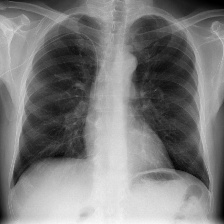

In [13]:
cv2_imshow(noncovid_images[3])

### **Normalization**


In [14]:

covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [15]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test= train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train
                          ), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test),
                        axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train
                          ), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test),
                        axis=0)




y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### **Building and Visualizing model**

In [8]:

vggModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


# our layers - you can add more if you want
outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)


# create a model object
model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

    
model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### **Image Augmentation**
To train on images at different positions, angles, flips, etc

In [10]:

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [13]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
23/23 [==============================] - 9s 393ms/step - loss: 0.4057 - accuracy: 0.8152 - val_loss: 0.3014 - val_accuracy: 0.8617
Epoch 2/500
23/23 [==============================] - 9s 392ms/step - loss: 0.3680 - accuracy: 0.8404 - val_loss: 0.2627 - val_accuracy: 0.8883
Epoch 3/500
23/23 [==============================] - 9s 394ms/step - loss: 0.3744 - accuracy: 0.8218 - val_loss: 0.2993 - val_accuracy: 0.8404
Epoch 4/500
23/23 [==============================] - 10s 418ms/step - loss: 0.4095 - accuracy: 0.8165 - val_loss: 0.2814 - val_accuracy: 0.8723
Epoch 5/500
23/23 [==============================] - 9s 390ms/step - loss: 0.3812 - accuracy: 0.8338 - val_loss: 0.2315 - val_accuracy: 0.9149
Epoch 6/500
23/23 [==============================] - 9s 401ms/step - loss: 0.3136 - accuracy: 0.8684 - val_loss: 0.2939 - val_accuracy: 0.8564
Epoch 7/500
23/23 [==============================] - 9s 393ms/step - loss: 0.3162 - accuracy: 0.8590 - val_loss: 0.2038 - val_accuracy: 0.925

In [14]:
model.save('vgg_chest.h5')

In [15]:
model.save_weights('vggweights_chest.hdf5')

In [16]:
model = load_model('vgg_chest.h5')

## Visualization

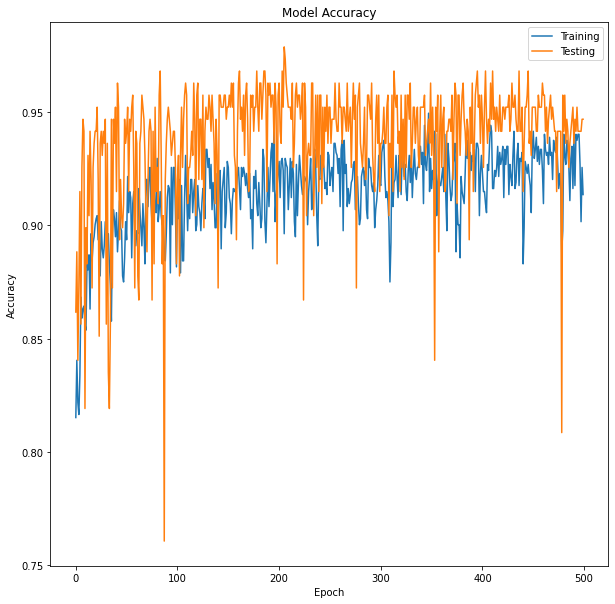

In [17]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_acc.png')
plt.show()

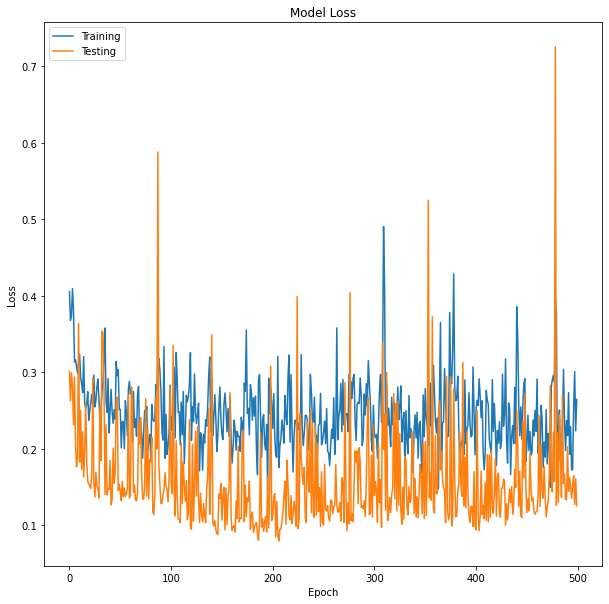

In [18]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()

In [17]:
y_pred = model.predict(X_test, batch_size=batch_size)

## Predictions

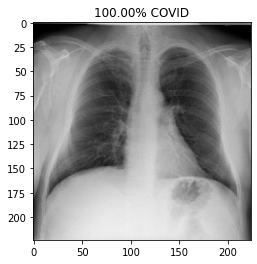

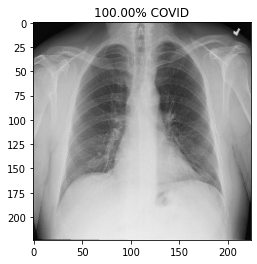

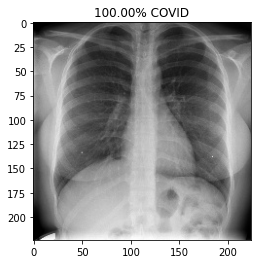

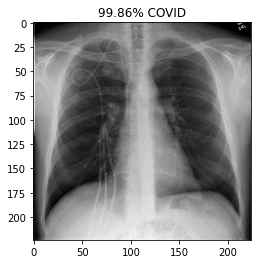

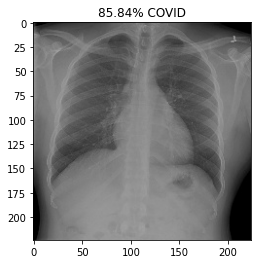

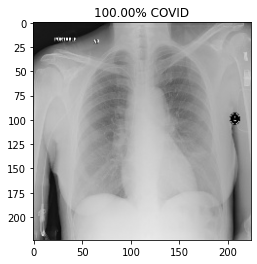

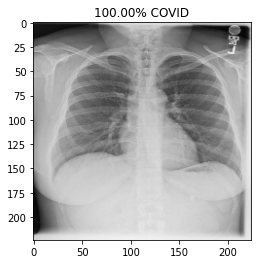

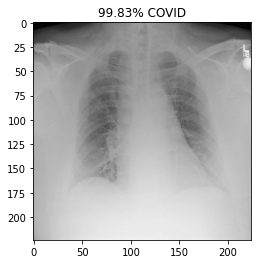

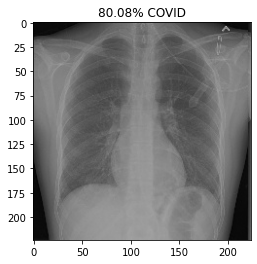

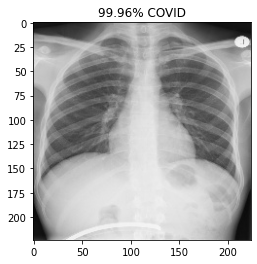

In [18]:
prediction = y_pred[0:10]

for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
    plt.title('%0.2f'% (probability[1]*100) + '% COVID')
  else:
    plt.title('%0.2f'% (1 - probability[1]*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()


In [19]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

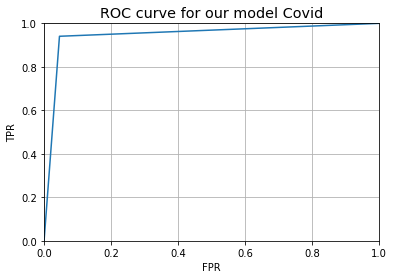

In [23]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model Covid')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)

In [24]:
confusion_matrix(y_test_bin, y_pred_bin)

array([[83,  4],
       [ 6, 95]])

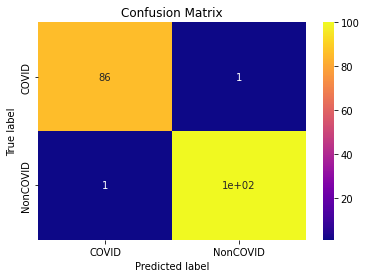

In [21]:
def plot_confusion_matrix():
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        87
           1       0.99      0.99      0.99       101

    accuracy                           0.99       188
   macro avg       0.99      0.99      0.99       188
weighted avg       0.99      0.99      0.99       188

